<a href="https://colab.research.google.com/github/nortonvanz/ML_Pocket_Reference/blob/main/notebooks/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resolução do Titanic utilizando CRISP-DM, seguindo o livro Machine Learning: Guia de Referência Rápica.

# Faça uma pergunta

Crie um modelo preditivo, que classifique se um indivíduo sobreviveu à catástrofe do Titanic (sim / não).

# Colete os Dados

## Imports

In [121]:
#Pandas Profling:
#!pip install ydata-profiling==4.1.2 #usar esta versão para o ydata-profiling funcionar no Colab

#Análise de Colunas Colineares
#!pip install rfpimp

  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=8e755e6b7642b8159e0c5a55371394f2b41c1a08d8151553de8b3f84ab289181
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp


In [133]:
import pandas as pd
import numpy as np
#from ydata_profiling import ProfileReport #é o antigo pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import missingno
import rfpimp


#sklearn aux
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn import preprocessing as pp
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.impute import SimpleImputer

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features import RFECV

## Carregar Dados

In [2]:
#Carrega datasets do github:
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/gender_submission.csv
!wget --quiet --show-progress https://hbiostat.org/data/repo/titanic3.xls -> mesma estrutura do livro

gender_submission.c 100%[===================>]   3.18K  --.-KB/s    in 0s      
titanic3.xls        100%[===================>] 277.50K  --.-KB/s    in 0.09s   


In [3]:
df_raw = pd.read_excel('titanic3.xls')
df_sub = pd.read_csv('gender_submission.csv')

In [4]:
df_raw.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
df_sub.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [6]:
df = df_raw.copy()

## Renomear Colunas

In [ ]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [7]:
#converter tudo para minúsculo e com underline no lugar de espaços e pontos
df.columns = df.columns.str.replace(' ','_').str.replace('.','_').str.lower()
df.columns

<ipython-input-7-92dceb22e649>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(' ','_').str.replace('.','_').str.lower()


Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home_dest'],
      dtype='object')

In [8]:
df.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Análise Preliminar

In [9]:
#descrição geral:
df.describe()
#count -> desconsidera NaN

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [ ]:
#Usar o Pandas Profiling para uma inspeção preliminar
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Limpe os Dados

Objetivo é poder usar dados em um modelo. Para isto, será necessário avaliar:
- formato numérico (int ou float)
- valores ausentes (NaN no pandas)
- padronização (média 0 e std 1). Isto porque alguns modelos terão melhor desempenho.
- leaky features (vazam resposta no treino)

Colunas com pouca variação (não informativas) também são limpadas, dado que não serão úteis ao modelo. Não é o caso neste dataset.

In [10]:
df.shape

(1309, 14)

In [11]:
df.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Dados Faltantes

In [12]:
#conferir nulos:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home_dest     564
dtype: int64

In [13]:
# % de nulos
np.round(df.isnull().mean() *100)

pclass        0.0
survived      0.0
name          0.0
sex           0.0
age          20.0
sibsp         0.0
parch         0.0
ticket        0.0
fare          0.0
cabin        77.0
embarked      0.0
boat         63.0
body         91.0
home_dest    43.0
dtype: float64

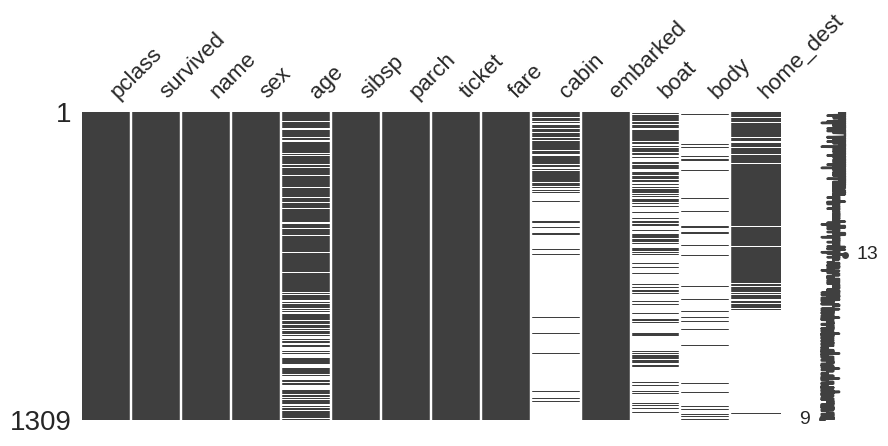

In [14]:
#avaliar se há algum padrão nos nulos com lib missingno
missingno.matrix(df, figsize=(10, 4));

In [15]:
#home.dest tem poucos missing para aprox. os primeiros 800 registros, depois praticamente todos são nulos.

In [16]:
#ações a respeito dos nulos:

# cabin, boat e body tem mais da metade de dados nulos, logo tendem a não ser relevantes e serão descartadas
# body tem alta correlação com survived (target), logo causa vazamento de dados e será descartada
# boat também causa vazamento, informando que o passageiro sobreviveu, logo também será discartada
# home.dest também tem mais de 40% de nulos, e será descartada

In [17]:
#analisar colunas object que tendem a ser categóticas, com value_counts()
df.sex.value_counts()

male      843
female    466
Name: sex, dtype: int64

In [18]:
#o pandas ignora NAN por padrão, para exibir:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

Algumas possibilidades para tratamento de NANs (dados ausentes):
- imputar valor mais comum -> sklearn SimpleImputer
- one hot encoding, onde será 0 em todas colunas
- explorar dados e imputar com alguma outra lógica

Em último caso:
- descartar linhas -> df.dropna()
- descartar colunas -> df.drop(columns="col_name")

In [19]:
#imputar dados na coluna boat, apenas como exemplo:
df.boat.value_counts(dropna=False)[:8]

NaN    823
13      39
C       38
15      37
14      33
4       31
10      29
5       27
Name: boat, dtype: int64

In [20]:
#5 primeiras linhas
df.boat[:5]

0      2
1     11
2    NaN
3    NaN
4    NaN
Name: boat, dtype: object

In [21]:
#imputar o valor mais frequente
imputer = SimpleImputer(missing_values = np.nan, strategy ='most_frequent') # média   #strategy='median' ou 'most_frequent'
df.boat = imputer.fit_transform(df["boat"].values.reshape(-1, 1))

In [22]:
#após dados imputados
df.boat[:5]

0     2
1    11
2    13
3    13
4    13
Name: boat, dtype: object

In [23]:
#dropar colunas, conforme planejado
df = df.drop( columns = ["name","ticket","home_dest","boat","body","cabin"] )

In [24]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [25]:
#temos colunas com NAN que permaneceram no dataset, e vamos tratar
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [26]:
#age e median: para estas colunas que tem NULLs e são float, vamos imputar a mediana da coluna
#poderia usar o mesmo método acima, com a estratégia = median

# medianas
meds = df[["age","fare"]].median()
meds

age     28.0000
fare    14.4542
dtype: float64

In [27]:
df[["age","fare"]] = df[["age","fare"]].fillna(meds)
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    2
dtype: int64

In [28]:
#para resolver os 2 missings de embarked (object), usar a abordagem mais frequente, já utilizada antes:

imputer2 = SimpleImputer(missing_values = np.nan, strategy ='most_frequent') # média   #strategy='median' ou 'most_frequent'
df.embarked = imputer2.fit_transform(df["embarked"].values.reshape(-1, 1))

In [29]:
#resolvido
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

## Tipos de dados

In [30]:
df.dtypes
# vemos normalmente int, float, datetime e object(string)
# o pandas tenta inferir, e seta object quando não conseguir identificar

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

In [31]:
#age possui valores float, o que é curioso
#poderia arredondar para int, mas como vamos normalizar os dados, será mantido assim mesmo
df.age[:5]

0    29.0000
1     0.9167
2     2.0000
3    30.0000
4    25.0000
Name: age, dtype: float64

# Crie as Features

In [32]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [33]:
#criar dummies a partir das 2 colunas categóricas, para ter cada categoria em uma coluna
df = pd.get_dummies(df)

In [34]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,0,1
3,1,0,30.0000,1,2,151.5500,0,1,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,0,1


In [35]:
# Temos agora colunas com correlação perfeita (sex_female vs sex_male), logo removeremos uma delas.
# Removemos também colunas com alta correlação positiva ou negativa, pois explicam a mesma parte do fenômeno.
# Além disso, a multicolinearidade pode causar impactos na interpretação das feature importances e dos coeficientes de alguns modelos.

In [36]:
df = df.drop(columns="sex_male")

In [37]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,1
1,1,1,0.9167,1,2,151.5500,0,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,1
3,1,0,30.0000,1,2,151.5500,0,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,1


# Separe as Amostras

Separação entre features e var alvo:

Termos para os dados:

X -> features

y -> Target

In [38]:
y = df.survived #criar uma Series
X = df.drop(columns="survived") #criar novo DataFrame

In [39]:
y.head(3)

0    1
1    1
2    0
Name: survived, dtype: int64

In [40]:
X.head(3)

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,1
1,1,0.9167,1,2,151.5500,0,0,0,1
2,1,2.0000,1,2,151.5500,1,0,0,1


Separação entre treino e teste

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

# EDA

In [57]:
X

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,1
1,1,0.9167,1,2,151.5500,0,0,0,1
2,1,2.0000,1,2,151.5500,1,0,0,1
3,1,30.0000,1,2,151.5500,0,0,0,1
4,1,25.0000,1,2,151.5500,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1304,3,14.5000,1,0,14.4542,1,1,0,0
1305,3,28.0000,1,0,14.4542,1,1,0,0
1306,3,26.5000,0,0,7.2250,0,1,0,0
1307,3,27.0000,0,0,7.2250,0,1,0,0


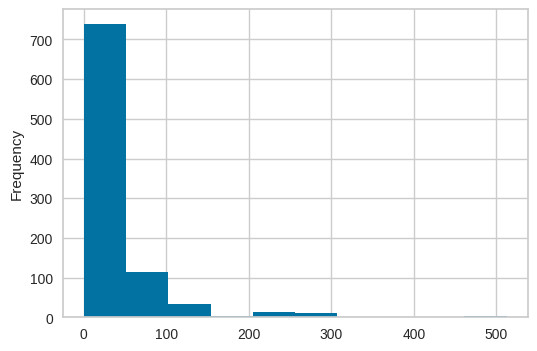

In [58]:
#histograma: mostra a distribuição dos dados

#fare
fig, ax = plt.subplots(figsize=(6, 4));
X_train.fare.plot(kind="hist", ax=ax);

In [ ]:
#a grande maioria dos passageiros tinha uma fare baixa

In [66]:
#Juntando X_train com y_train, para aprofundar as análises:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S,survived
239,1,31.0,0,0,50.4958,0,0,0,1,0
934,3,4.0,0,2,22.0250,1,0,0,1,1
290,1,52.0,1,1,79.6500,0,0,0,1,0
1089,3,20.0,0,0,9.2250,0,0,0,1,0
1161,3,16.0,0,0,8.0500,0,0,0,1,0


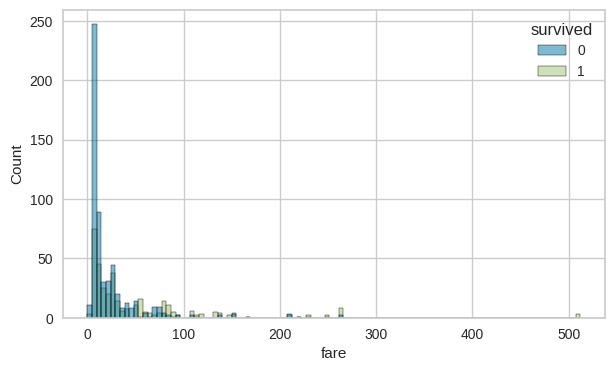

In [69]:
# #usando seaborn
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(data=df_train, x="fare", hue="survived");

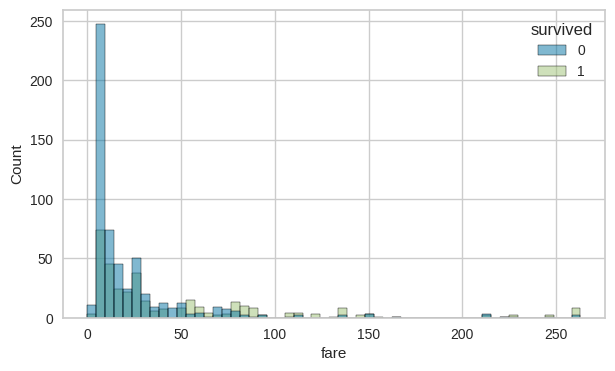

In [73]:
#remover fare > 300, para melhor visualizar
df_train_fare300 = df_train.loc[df_train.fare < 300]

fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(data=df_train_fare300, x="fare", hue="survived");

In [ ]:
#percebe-se que há mais sobreviventes entre os passageiros com fare maior

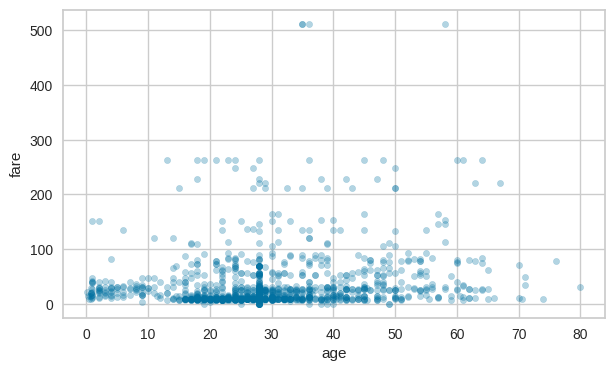

In [75]:
#gráfico de dispersão: mostra o relacionamento entre duas colunas numéricas
#cruzando fare com age
fig, ax = plt.subplots(figsize=(7, 4));
X.plot.scatter(x="age", y="fare", ax=ax, alpha=0.3);

In [ ]:
#Não parece haver muita correlação entre esses dois atributos.

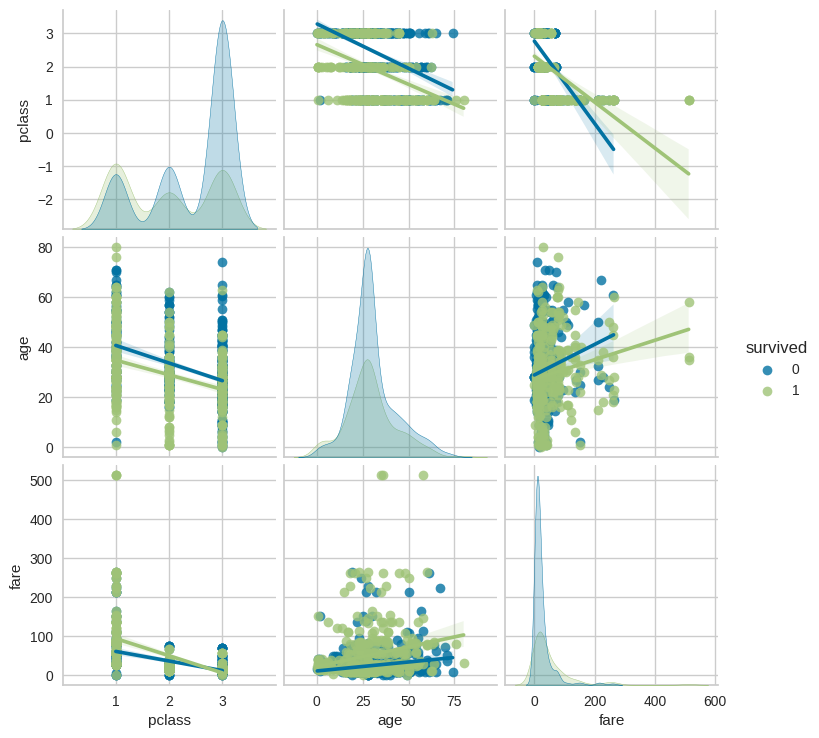

In [90]:
#matriz de pares
#fig, ax = plt.subplots(figsize=(6, 6))

vars = ["pclass", "age", "fare"]
sns.pairplot(df_train, vars=vars, hue="survived", kind="reg");

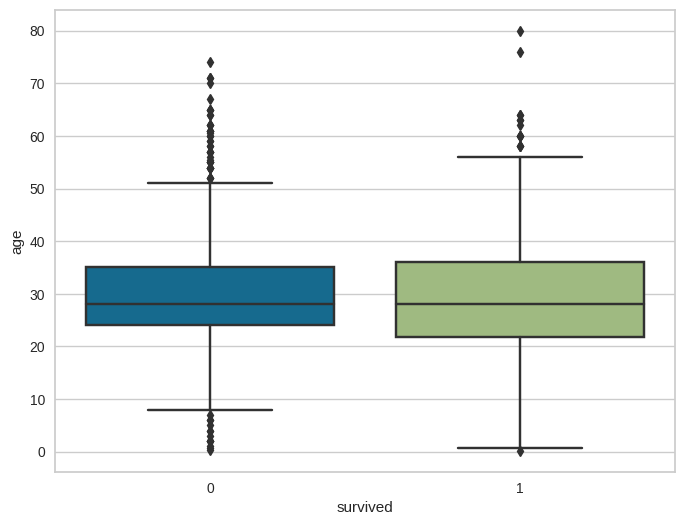

In [92]:
#Boxplot: mostra a distribuição dos dados
#age
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x="survived", y="age", data=df_train);

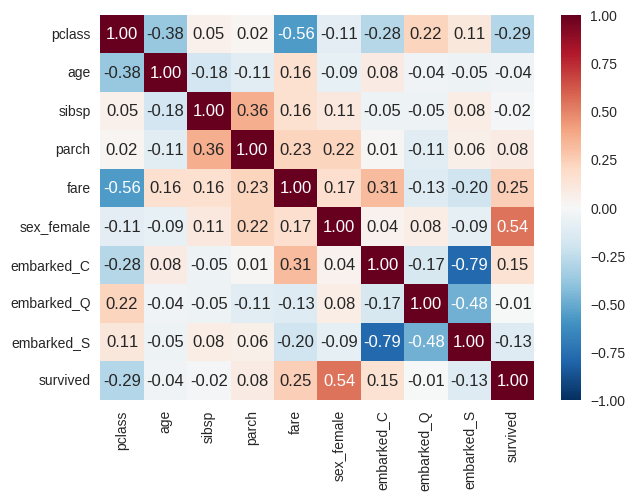

In [100]:
#Correlação

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(df_train.corr(),fmt=".2f",annot=True,ax=ax,cmap="RdBu_r",vmin=-1,vmax=1);

In [ ]:
#há uma correlação média negativa entre cada um dos 3 locais de embarque
#fare possui correlação média com pclass

<ipython-input-101-3c5e396cf015>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


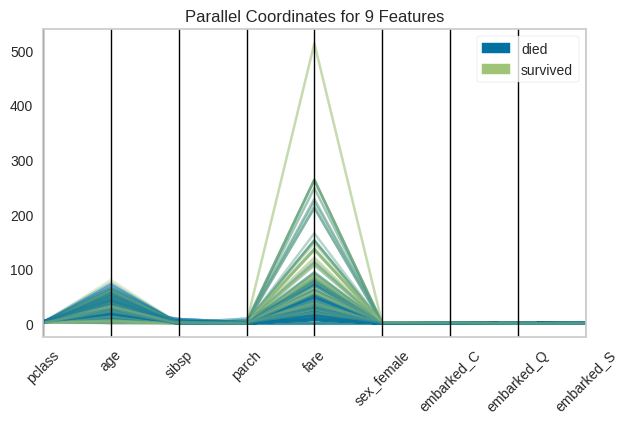

In [101]:
#Gráfico de coordenadas paralelas, para visualizar os agrupamentos
from yellowbrick.features import ParallelCoordinates

fig, ax = plt.subplots(figsize=(7, 4))
pc = ParallelCoordinates(
classes=["died", "survived"],
features=X.columns,
)
pc.fit(X_train, y_train)
pc.transform(X_train)
ax.set_xticklabels(
ax.get_xticklabels(), rotation=45
)
pc.poof();

In [ ]:
#há um maior número de sobreviventes nas faixas de fare mais elevadas

# Normalize os dados

In [ ]:
#Normalizar os dados ajudará os modelos que dependem de métrica de distâncias a terem um melhor desempenho.
#Assim, os modelos não tratarão as variáveis com escalas maiores, como mais importantes que as que tem escalas menores.
#Árvores não tem este requisito.

#Standardizarion: É Redimensionar os dados para ter uma média de 0 e um desvio padrão de 1 (unidade de variância).
  #Sklean: "standardize features by removing the mean and scaling to unit variance."

In [ ]:
#as variáveis dummy podem ser ignoradas, sendo binárias.

In [102]:
X_train.parch.value_counts()

0    710
1    105
2     84
3      6
5      4
4      4
9      2
6      1
Name: parch, dtype: int64

In [103]:
#X_train2 =X_train.copy()
#X_train = X_train2.copy()

In [104]:
X_train.columns #9 cols

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [105]:
#usando standard scaler: (premissa: dados tem distribuição normal)

#instancia
sca = pp.StandardScaler()

In [106]:
X_train.head(1)

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
239,1,31.0,0,0,50.4958,0,0,0,1


In [107]:
#Standardizarion em X_train (transforma em array numpy)
X_train_aux = sca.fit_transform(X_train)
X_train_aux[:1]

array([[-1.50369704,  0.0799764 , -0.48339886, -0.43145959,  0.31207531,
        -0.76470588, -0.52513428, -0.31982245,  0.66863847]])

In [108]:
#nomes das colunas
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S']

In [109]:
#retorna ao formato df
X_train = pd.DataFrame(X_train_aux, columns=cols)
X_train[:1]

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,-1.503697,0.079976,-0.483399,-0.43146,0.312075,-0.764706,-0.525134,-0.319822,0.668638


In [110]:
#aplica as mesmas transformações para os dados de teste:
X_test_aux = sca.fit_transform(X_test)
X_test = pd.DataFrame(X_test_aux, columns=cols)
X_test[:1]

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,0.812891,-0.11141,-0.473296,-0.481018,-0.460637,-0.694996,-0.473602,-0.327173,0.623452


# Selecione as Features

In [111]:
#já foi feita uma seleção prévia de fatures na etapa de limpeza de dados

#O objetivo da features selection é selecionar as features úteis para o modelo.
#Maldição da dimensionalidade: problema causado pelo aumento exponencial do volume associado à adição de dimensões extras (features) ao espaço euclidiano

## Remover features colineares

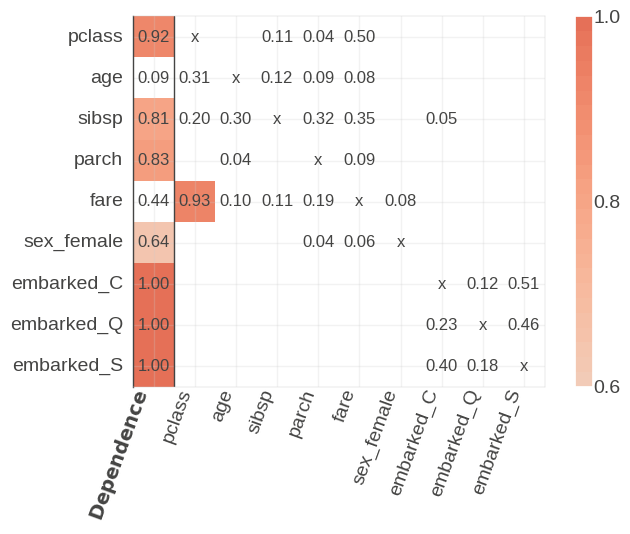

In [124]:
#Uma estratégia para remover features desnecessárias é remover colunas colineares

#Podemos usar a função correlated_columns para encontrar colunas visualmente, colunas que tenham um coeficiente de correlação maior ou igual a 0,95:

#A função plot_dependence_heatmap faz o treinamento de uma floresta aleatória (random forest) para cada coluna numérica a partir das outras colunas em um conjunto de dados de treinamento.
#O valor da dependência é a pontuação R2 das estimativas OOB (Out-Of-Bag) para a predição dessa coluna

rfpimp.plot_dependence_heatmap(
rfpimp.feature_dependence_matrix(X_train),
value_fontsize=12,
label_fontsize=14)
fig = plt.gcf()

In [ ]:
#A forma sugerida de usar esse gráfico é encontrar valores próximos de 1. O rótulo no eixo X é o atributo que faz a predição do rótulo do eixo Y.
#Se um atributo faz a predição de outro, podemos remover o atributo previsto (o atributo no eixo Y).
#Em nosso exemplo, fare pode ser previso através de pclass. Logo, será removido, por conter um conteúdo de informação quase igua a pclass.

In [130]:
df_train = df_train.drop(['fare'], axis=1)

In [131]:
df_train.head(3)

,pclass,age,sibsp,parch,sex_female,embarked_C,embarked_Q,embarked_S,survived
239,1,31.0,0,0,0,0,0,1,0
934,3,4.0,0,2,1,0,0,1,1
290,1,52.0,1,1,0,0,0,1,0


## Eliminação recursiva de features

RFECV(ax=<Axes: >, cv=5, estimator=RandomForestClassifier())

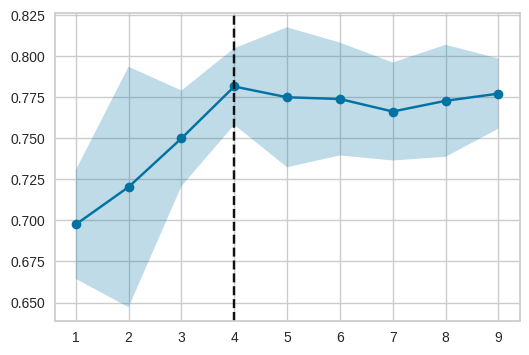

In [150]:
#A eliminação recursiva de atributos removerá os atributos mais fracos, e então treinará um modelo

fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(RandomForestClassifier(n_estimators=100),cv=5)
rfe.fit(X_train, y_train)

In [158]:
#manter as 4 features, pois foi com as 9 que obtivemos um melhor resultado
X_train.columns[rfe.support_]

Index(['pclass', 'age', 'fare', 'sex_female'], dtype='object')

# Modelo Base

In [ ]:
#o DummyClassifier serve como um modelo realmente simples, para dar uma ideia de como está nossos outros modelos:
  #por defaul, usa como stratrgy: “prior”: the predict method always returns the most frequent class label in the observed y argument passed to fit.

In [ ]:
y_train.value_counts()

0    564
1    352
Name: survived, dtype: int64

In [ ]:
#vai prever sempre 0 (survived = Não)

In [ ]:
#instanciar
bm = DummyClassifier()
#fitar com treino
bm.fit(X_train, y_train)
#obter precisão em teste
bm_score = bm.score(X_test, y_test)
bm_score

0.6234096692111959

In [ ]:
#o modelo Dummy que chuta sempre a classe majoritária, tem 62% de precisão.
#Considerar que precisão é uma métrica que se torna enganosa, com dados desbalanceados: se eu tiver 1 caso positivo de 10k negativos, prevendo tudo negativo, um modelo poderia ter 99% de precisão.

# Modelos Diversos

In [ ]:
#juntar treino num só dataframe
X = pd.concat([X_train, X_test])
#juntar teste num só dataframe
y = pd.concat([y_train, y_test])


for model in [
  DummyClassifier,
  LogisticRegression,
  DecisionTreeClassifier,
  KNeighborsClassifier,
  GaussianNB,
  SVC,
  RandomForestClassifier,
  xgboost.XGBClassifier
]:

  cls = model()
  kfold = KFold(n_splits=10)

  #aplica cross validation, e avalia a performance com AUC: Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    #A métrica AUC é o valor da área abaixo da curva ROC, quanto maior esse valor, maior a performance de separação do algoritmo.
  s = cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)

  #resultados
  print(f"{model.__name__:22}   AUC:{s.mean():.3f}     STD: {s.std():.2f}")

  #um algoritmo que tenha um AUC um pouco menor que outro, mas um desvio-padrão menor, pode ser uma melhor opção.

DummyClassifier          AUC:0.500     STD: 0.00
LogisticRegression       AUC:0.842     STD: 0.03
DecisionTreeClassifier   AUC:0.722     STD: 0.04
KNeighborsClassifier     AUC:0.826     STD: 0.03
GaussianNB               AUC:0.813     STD: 0.04
SVC                      AUC:0.844     STD: 0.04
RandomForestClassifier   AUC:0.826     STD: 0.04
XGBClassifier            AUC:0.822     STD: 0.03


In [ ]:
#O SVC foi o modelo que melhor performou. Considerar que não foi feita tunagem alguma de hiperparâmetros.

# Crie o modelo

In [ ]:
#Usaremos um RF, que tende a ter bons resultados sem maior tuning.

In [ ]:
#instanciar
rf = RandomForestClassifier(n_estimators=100, random_state=42)
#fitar
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Avalie o modelo

In [ ]:
#Avaliar se o modelo consegue generalizar bem em dados de teste (nunca antes vistos)

In [ ]:
#Vamos usar a métrica acurácia aqui: quantas predições acertei do total (ainda que o dataset tenha algum desbalanceamento, e não seria a mais adequada)
round(rf.score(X_test, y_test),3)

0.794

In [ ]:
#O mesmo pode ser obtido via lib metrics:

# Accuracy
y_hat = rf.predict(X_test)
round(metrics.accuracy_score( y_test, y_hat ),3)

0.794

In [ ]:
#usando F1-Score: Resume precision e recall, sendo a média harmônica entre ambos.
round(metrics.f1_score( y_test, y_hat ),3)

0.687

In [ ]:
#Inspecionar Feature importances: informa quanto cada feature contribui para o modelo. Quanto maior o erro causado com a remoção da feature, maior é a sua importância.
importances = rf.feature_importances_

In [ ]:
print("Features mais importantes:")
for col, val in sorted(
    zip(
        X_train.columns,
        rf.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
):
  print(f"{col:10}{val:10.3f}")

Features mais importantes:
fare           0.289
sex_female     0.268
age            0.249
pclass         0.077
sibsp          0.045
parch          0.038
embarked_C     0.014
embarked_S     0.013
embarked_Q     0.006


# Otimize o Modelo

In [ ]:
#O autor exemplivida com o Grid Search CV. Ele funciona bem para datasets pequenos, como este.
rfh = RandomForestClassifier()
params = {
    "n_estimators": [80, 300],
   # "min_samples_leaf": [2, 5],
   # 'max_leaf_nodes': [20, 40, 60],
    'max_depth': [3, 5, 8], #já controla o crescimento da árvore
    "random_state": [42]
}

rfcv = GridSearchCV(rfh, params, n_jobs=-1).fit(X_train, y_train)
print(f"Os melhores parâmetros são: {rfcv.best_params_}")

Os melhores parâmetros são: {'max_depth': 5, 'n_estimators': 300, 'random_state': 42}


In [ ]:
#usar este modelo com melhores params no nosso dataset:
rfcv.fit(X_train, y_train)
rff_yhat = rfcv.predict(X_test)

#performance considerando acurácia
metrics.accuracy_score(y_test, rff_yhat)

0.811704834605598

In [ ]:
# a acurácia melhorou, vamos verificar o F-1 score:
round(metrics.f1_score( y_test, rff_yhat ),3)

0.722

In [ ]:
#medindo com F1-Score, também houve uma melhor performance após o fine tuning

In [ ]:
#Importante lembrar: o fine tuning do GridSearchCV vai aumentar pouco a performance do modelo.
#Investir mais energia na feature engeneering e feature selection, vai gerar mais ganho de performance.

In [ ]:
#salvar com pickle no Colab
pickle_out = open("rfcv_pickle", 'wb')
pickle.dump = (rfcv, pickle_out)

In [ ]:
#carregar
pic = pickle.dumps(rfcv)
rfcv2 = pickle.loads(pic)

In [ ]:
rfcv2

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8], 'n_estimators': [80, 300],
                         'random_state': [42]})

# Matriz de Confusão

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = rfcv.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[223,  22],
       [ 52,  96]])

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


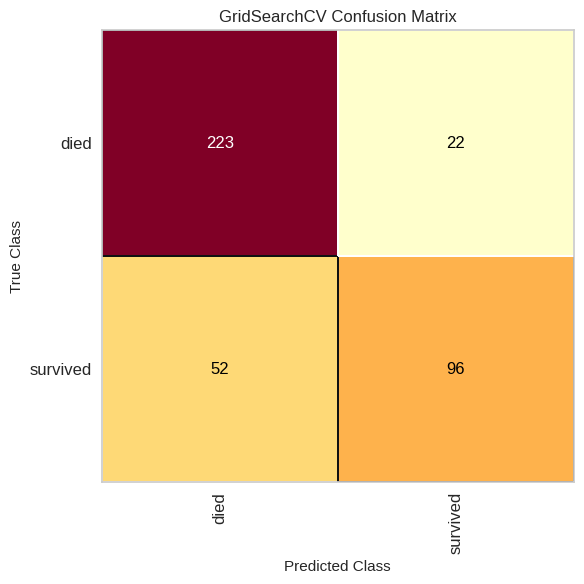

In [ ]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
  rfcv,
  classes=["died", "survived"],
  label_encoder=mapping,
)
cm_viz.score(X_test, y_test);
cm_viz.poof();

In [ ]:
#Um bom classificador teria todos os valores na diagonal principal, e zeros nas demais células.

# Curva de Aprendizado

In [ ]:
#É usada para nos dizer se temos dados de treinamento suficientes.
#O modelo é treinado com porções cada vez maiores dos dados e a pontuação é calculada

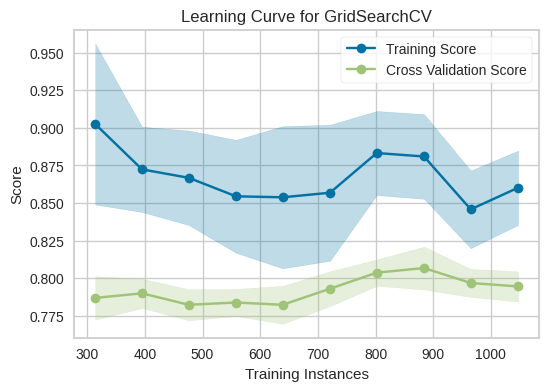

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(rfcv, cv=cv, train_sizes=sizes, scoring="f1_weighted", n_jobs=-1, ax=ax)
lc_viz.fit(X, y)
lc_viz.poof();

In [ ]:
#Essa curva de aprendizado mostra que, à medida que adicionamos mais amostras para treinamento, até aprox 900 linhas, nossas pontuações de validação cruzada (testes) parecem melhorar.
#Depois, há uma aparente estabilização.